# TP n°2 - Linear Image Denoising

Adapted from Gabriel Peyré's http://www.numerical-tours.com/

This notebook aims to familiarize you with the Fourier transform and with image manipulation.

In [123]:
# Imports

import numpy as np
import matplotlib.pyplot as plt

from skimage.data import astronaut
from skimage.transform import resize
from skimage.color import rgb2gray

## Loading an image

Let us start by loading a picture and displaying it.

In [124]:
# Loading the image.
x0 = astronaut()

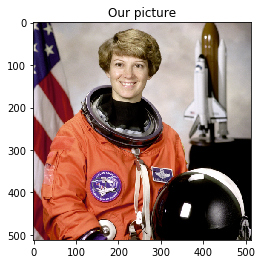

In [125]:
# To plot an image, use `plt.imshow`.
plt.imshow(x0)
plt.title("Our picture")
plt.show()

Let us resize this image to $n\times n$, and turning it into a grayscale image.

In [126]:
n = 256
N = n**2

# Resizing the image.
x0 = resize(x0, (n, n))

# Converting the image to grayscale.
x0 = rgb2gray(x0)

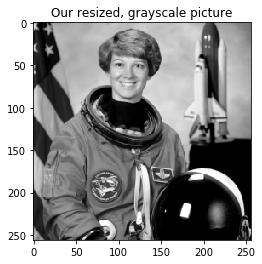

In [127]:
# Tip: to plot a grayscale image in gray instead of the default green, use `cmap="gray"`.
plt.imshow(x0, cmap="gray")
plt.title("Our resized, grayscale picture")
plt.show()

## Adding noise to the image.

We will simulate noisy acquisition by adding some
white noise (each pixel is corrupted by adding an independant Gaussian
variable).

This is useful to test in an oracle manner the performance of our methods.

We add some noise to the image to obtain the noisy signal $y = x_0 + w$.
Here $w$ is a realization of a Gaussian white noise of variance
$\sigma^2$.

In [128]:
# Define the variance of the noise.
sigma = .08

# Define the noisy image.
y = x0 + sigma*np.random.standard_normal(x0.shape)

**Question 1:** Plot the noisy image. 

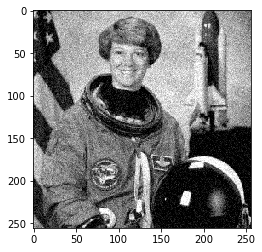

In [119]:
# Tip: Because of the noise, some values may not be in [0, 1] anymore!
# To clip the values of an array, use `np.clip`.
plt.imshow(np.clip(y, 0, 1), cmap='gray')
plt.show()

## Linear Image Denoising

We consider a noising estimator $x \in \mathbb R^N$ of $x_0$ that only
depends on the observation $y$. Mathematically speaking, it is thus a
random vector that depends on the noise $w$.


A translation invariant linear denoising is necessarely a convolution
with a kernel $h$
$$ x = x_0 \star h $$
where the periodic convolution between two 2-D arrays is defined as
$$ (a \star b)_i = \sum_j a(j) b(i-j). $$


It can be computed over the Fourier domain as
$$ \forall \omega, \quad \hat x(\omega) = \hat x_0(\omega) \hat h(\omega). $$

In [129]:
# Define the convolution function.
cconv = lambda a,b : np.real(np.fft.ifft2(np.fft.fft2(a)*np.fft.fft2(b)))

# `np.fft.fft2` is the 2D Fourier transform.
# `np.fft.ifft2` is the inverse 2D Fourier transform.
# `np.real` is the real part of a complex number.
# Here, we need to convert to a real number to get rid of the imaginary part (which should be 0).

Let us define a gaussian filter parametrized by its bandwidth mu.

In [130]:
normalize = lambda h: h / np.sum(h.flatten()) # L1 normalization.
t = np.concatenate((np.arange(0, n / 2), np.arange(-n / 2, 0))).T
yy, xx = np.meshgrid(t, t)
h = lambda mu: normalize(np.exp(-(xx**2 + yy**2) / (2 * mu**2)))

Display the filter $h$ and its Fourier transform. Note the $\hat h$ is a real-valued function.

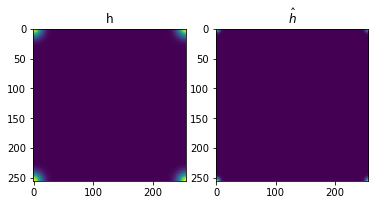

In [133]:
mu = 10
fig, axes = plt.subplots(1, 2)
axes[0].imshow(h(mu))
axes[0].set_title('h')
axes[1].imshow(np.real(np.fft.fft2(h(mu))))
axes[1].set_title('$\hat h$')
plt.show()

Notice that because the filter is centered around 0, it's localized in the egdes of the images.

To improve readability, we can use `np.fft.fftshift`.

**Question 2:** Use `np.fft.fftshift` to show the centered filter and it's Fourier transform.

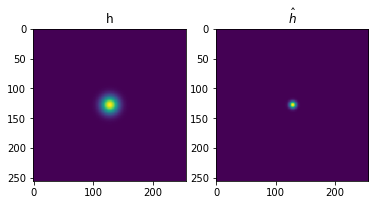

In [136]:
mu = 10
fig, axes = plt.subplots(1, 2)
axes[0].imshow(np.fft.fftshift(h(mu)))
axes[0].set_title('h')
axes[1].imshow(np.fft.fftshift(np.real(np.fft.fft2(h(mu)))))
axes[1].set_title('$\hat h$')
plt.show()

**Question 3:** Define the denoising function $x \mapsto h_\mu \star x$ and display the denoised signal for several values of $\mu$

In [138]:
def denoise(x, mu):
    return cconv(h(mu), x)

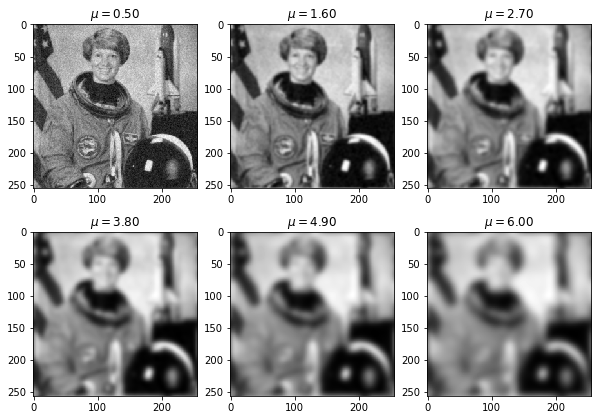

In [139]:
fig, axes = plt.subplots(2, 3, figsize=(10, 7))
for i, mu in enumerate(np.linspace(.5, 6, 6)):
    axes.ravel()[i].set_title(r"$\mu = {:.2f}$".format(mu))
    axes.ravel()[i].imshow(denoise(y, mu), cmap="gray")
plt.show()

**Question 4:** Display the evolution of the oracle denoising error
$ ||y-x_0|| $ as a function of $\mu$.

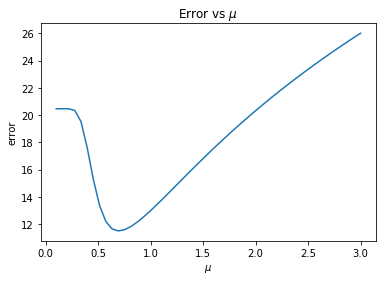

In [140]:
errors = []
mu_linspace = np.linspace(.1, 3, 50)
for mu in mu_linspace:
    errors.append(np.linalg.norm(x0 - denoise(y, mu)))
plt.plot(mu_linspace, errors)
plt.xlabel('$\mu$')
plt.ylabel('error')
plt.title('Error vs $\mu$')
plt.show()

**Question 5:** Set $\mu$ to the value of the optimal parameter and display the results.

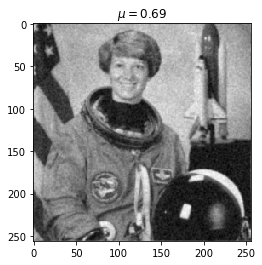

In [141]:
best_mu = mu_linspace[np.argmin(errors)]
plt.title(r"$\mu = {:.2f}$".format(best_mu))
plt.imshow(denoise(y, best_mu), cmap="gray")
plt.show()

## Wiener Filtering

We suppose here that $x_0$ is a realization of a random vector $x_0$,
whose distribution is Gaussian with a stationary covariance $c$,
and we denote $P_{X_0}(\omega) = \hat c(\omega)$ the power-spectrum of
$x_0$.


Recall that $w$ is a realization of a random vector $W$
distributed according to $\mathcal N(0,\sigma^2 \text{Id})$.


The (oracle) optimal filter minimizes the risk
$$ R(h) = \mathbb E_{W,X_0}( || X_0 - h \star (X_0 + W) ||^2 ). $$


One can show that the solution of this problem, the so-called Wiener filter,
is defined as
$$ \forall \omega, \quad \hat h(\omega) = \frac{ P_{X_0}(\omega) }{ P_{X_0}(\omega) + \sigma^2 }. $$


We estimate $ P_{X_0} $ using the periodogram associated to the
realization $x_0$, i.e.
$$ P_{X_0} \approx \frac{1}{N}|\hat x_0|^2. $$

In [81]:
P = 1/N * ( abs(np.fft.fft2(x0))**2 )

**Question 6:** Compute the approximate Wiener filter $\hat h(\omega)$.Note that this is a theoretical filter, because in practice one does not
have access to $x_0$. Display it.

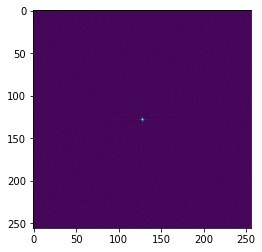

In [144]:
h_wiener = np.real(np.fft.ifft2(P / (P + sigma**2)))

# This might be a very small dot.
plt.imshow(np.fft.fftshift(h_wiener))
plt.show()

**Question 7:** Display the denoising result.

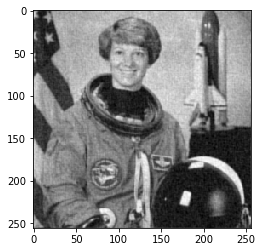

In [143]:
plt.imshow(cconv(y, h_wiener), cmap="gray")
plt.show()

Note that this denoising is not very efficient, because the hypothesis of
stationarity of $X_0$ is not realistic for such piecewise-regular
signal.